# Desafio: "Dados ENEM e IDH"
## Introdução
- Neste projeto, vamos analisar os dados do ENEM e do IDH para uma instituição filantrópica, que atua com projetos visando a melhoria da educação no ensino médio e do IDHM dos municípios com nível baixo ou muito baixo.
- Nosso objetivo é selecionar 100 escolas para receber 10 dólares por aluno/mês durante 12 meses, para turmas do ensino médio.
- O critério de escolha das escolas será: municípios que possuem menores valores de IDHM, mas que tenham escolas de ensino médio com alunos que fizeram o ENEM. Em caso de empate no valor do IDHM, escolheremos as cidades que possuírem menor média do ENEM. Como nos microdados do ENEM não podemos ter acesso às notas das escolas, utilizaremos os microdados do Censo Escolar da Educação Básica 2020 para selecionar as escolas que possuem mais alunos matriculados no Ensino Médio das cidades que escolhemos anteriormente. 
- Também foram propostas algumas questões que responderemos ao longo do projeto:
    - 1. Qual o valor total a ser investido, considerando que cada escola possui apenas 1 turma com 30 alunos para cada série do ensino médio? Quanto seria esse valor com a cotação do dólar de janeiro de 2019 e dezembro de 2020?
    - 2. Quais dados (arquivos) você utilizou, onde e como os coletou?
    - 3. Que tipo de tratamento você aplicou na base de dados?
    - 4. Qual a proporção de missing nas bases e o que você fará com esses casos? Na sua opinião, quais os mais relevantes?
    - 5. Qual o número de inscritos por ano? Existe alguma tendência a ser observada nos dados?
    - 6. Quais as notas médias por ano de realização da prova?
        - a. Nota da prova de Ciências da Natureza
        - b. Nota da prova de Ciências Humanas
        - c. Nota da prova de Linguagens e Códigos
        - d. Nota da prova de Matemática
        - e. Redação
        - f. Nota total (soma a+b+c+d+e)
    - 7. Quais escolas devem receber o investimento?


## Coleta de dados
- Para conseguir responder todas as perguntas, precisamos de cinco datasets (2ª questão):
    - 1. Cotação do dólar/real em janeiro de 2019 e dezembro de 2020: que temos acesso no [Portal de Dados Abertos do Banco Central do Brasil](https://dadosabertos.bcb.gov.br/dataset/1-taxa-de-cambio---livre---dolar-americano-venda---diario), para responder a primeira pergunta e calcular o valor total a ser investido pela ONG;
    - 2. Dados do IDHM: para selecionar os municípios que possuem os valores mais baixos do indicador, classificados como "Muito Baixo" ou "Baixo". Os dados do IDHM, bem como outros indicadores, podem ser acessados no site do [Atlas Brasil](http://www.atlasbrasil.org.br/consulta/planilha);
    - 3. Microdados do ENEM 2020: nosso segundo indicador para selecionar os municípios será a nota média do ENEM, para as cidades que possuem os menores valores do IDHM. Os microdados do ENEM 2020 podem ser acessados no site do [INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem);
    - 4. Microdados do Censo Escolar da Educação Básica 2020: para escolher as escolas que receberão o auxílio, nós vamos focar na quantidade de alunos matriculados no Ensino Médio. Os microdados podem ser acessados no site do [INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-escolar);
    - 5. Sinopses Estatísticas do Enem: como apenas os Microdados do ENEM de 2020 estão disponibilizados, utilizaremos as sinopses estatísticas com os dados gerais de cinco edições: 2020, 2019, 2018 e 2017. Elas podem ser acessadas no site do [INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/sinopses-estatisticas/enem).

### 1. Dólar/Real
- Vamos abrir o dataset do Banco Central do Brasil, fazer uma visão geral, checar valores faltantes e calcular os valores (1ª questão).

In [1]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
import json
import re
import dask.dataframe as dd
import geopandas as gpd

In [2]:
# Abrindo a série temporal
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.1/dados?formato=json&dataInicial=01/01/2019&dataFinal=31/12/2020'
dolar_real = pd.read_json(url)
dolar_real

,data,valor
0,31/12/2018,3.8748
1,02/01/2019,3.8595
2,03/01/2019,3.7683
3,04/01/2019,3.7627
4,07/01/2019,3.7062
...,...,...
500,24/12/2020,5.1800
501,28/12/2020,5.2390
502,29/12/2020,5.1942
503,30/12/2020,5.1967


In [3]:
# Visão geral do dataset
dolar_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    505 non-null    object 
 1   valor   505 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


### 2. IDHM
- Vamos abrir o dataset com o IDHM 2010 e outros indicadores sobre a educação que escolhemos, fazer uma visão geral e checar valores faltantes. Os outros datasets serão incluídos na seção de tratamento de dados à medida que formos selecionando os municípios e as escolas.

In [4]:
# Abrindo dataset com o idhm 2010
idhm = pd.read_excel('dataidhm.xlsx')
idhm.head()

,Territorialidades,IDHM 2000,IDHM 2010,IDHM Educação 2000,IDHM Educação 2010,% de matrículas da rede pública no ensino médio 2017,Taxa de Distorção Idade-Série no médio 2017,Taxa de Distorção Idade-Série no médio na rede pública 2017,% de alunos do ensino médio em escolas com laboratório de informática 2017,% de alunos do ensino médio em escolas com internet 2017,% de docentes do médio com formação adequada 2017,% de docentes na rede pública do médio com formação adequada 2017
0,Brasil,0.612,0.727,0.456,0.637,87.76,28.2,31.1,86.76,93.97,61.0,60.7
1,Abadia de Goiás (GO),0.569,0.708,0.386,0.622,100.00,29.0,29.0,0.00,100.00,48.5,48.5
2,Abadia dos Dourados (MG),0.575,0.689,0.387,0.563,100.00,13.3,13.3,100.00,100.00,59.5,59.5
3,Abadiânia (GO),0.503,0.689,0.292,0.579,53.73,15.4,20.6,46.27,100.00,44.8,36.3
4,Abaeté (MG),0.587,0.698,0.385,0.556,89.43,28.0,31.2,100.00,100.00,72.8,73.3


In [5]:
# Visão geral 
idhm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 12 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Territorialidades                                                           5568 non-null   object 
 1   IDHM 2000                                                                   5566 non-null   object 
 2   IDHM 2010                                                                   5565 non-null   float64
 3   IDHM Educação 2000                                                          5565 non-null   float64
 4   IDHM Educação 2010                                                          5565 non-null   float64
 5   % de matrículas da rede pública no ensino médio 2017                        5556 non-null   float64
 6   Taxa de Distorção Idade-Série no médio 2017     

- Percebemos que este dataset possui valores faltantes em todas as colunas, exceto "Territorialidades". Vamos checar essas colunas:

In [6]:
# Selecionando linhas com valores faltantes
idhm[idhm['IDHM 2010'].isnull()]

,Territorialidades,IDHM 2000,IDHM 2010,IDHM Educação 2000,IDHM Educação 2010,% de matrículas da rede pública no ensino médio 2017,Taxa de Distorção Idade-Série no médio 2017,Taxa de Distorção Idade-Série no médio na rede pública 2017,% de alunos do ensino médio em escolas com laboratório de informática 2017,% de alunos do ensino médio em escolas com internet 2017,% de docentes do médio com formação adequada 2017,% de docentes na rede pública do médio com formação adequada 2017
5565,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5566,Elaboração: Atlas do Desenvolvimento Humano no...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5567,Fontes: dados do IBGE e de registros administr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Podemos perceber que as linhas com os valores faltantes representam os elaboradores e as fontes. Podemos remover.

In [7]:
# Removendo linhas com elabroadores e fontes
idhm.drop(idhm.index[5565:], inplace=True)
idhm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5565 entries, 0 to 5564
Data columns (total 12 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Territorialidades                                                           5565 non-null   object 
 1   IDHM 2000                                                                   5565 non-null   object 
 2   IDHM 2010                                                                   5565 non-null   float64
 3   IDHM Educação 2000                                                          5565 non-null   float64
 4   IDHM Educação 2010                                                          5565 non-null   float64
 5   % de matrículas da rede pública no ensino médio 2017                        5556 non-null   float64
 6   Taxa de Distorção Idade-Série no médio 2017     

### 3. Sinopses Estatísticas do ENEM
- As sinopses estatísticas são arquivos disponibilizados pelo INEP com os dados e as descrições gerais de cada edição do ENEM. Cada ano da prova possui um arquivo .xlsx, então decidimos selecionar os dados dos números de inscritos e das médias de cada área no Excel mesmo, para não estender esse projeto.
- Criamos três arquivos, um com a quantidade de alunos inscritos em cada ano (2020-2017) e um com a soma das médias por área de conhecimento e o terceiro com as médias e outras medidas das notas de cada área de conhecimento, também em cada ano.
- Para abreviar o nome das áreas de conhecimento, vamos utilizar a seguinte legenda:
    - CN: Ciências da Natureza e suas tecnologias;
    - CH: Ciências Humanas e suas tecnologias;
    - LC: Linguagens, Códigos e suas tecnologias;
    - MT: Matemática e suas tecnologias e 
    - RD: Redação.

In [8]:
# Abrindo dataset com os inscritos do enem 2020-2017
inscritos = pd.read_excel('Inscritos ENEM 2020-2017.xlsx')
inscritos.head(6)

,Região Geográfica,Ano,Número de Inscritos
0,Brasil,2020,5783133
1,Norte,2020,731034
2,Nordeste,2020,1948494
3,Sudeste,2020,1982112
4,Sul,2020,608117
5,Centro-Oeste,2020,513376


In [9]:
# Visão geral
inscritos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Região Geográfica    24 non-null     object
 1   Ano                  24 non-null     int64 
 2   Número de Inscritos  24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 704.0+ bytes


In [10]:
# Abrindo dataset com as notas totais enem 2020-2017 
nota_total_enem = pd.read_excel('Notas totais ENEM 2020-2017.xlsx')
nota_total_enem.head()

,Região Geográfica,Ano,Média Total
0,Brasil,2020,2636.34
1,Norte,2020,2501.29
2,Nordeste,2020,2561.43
3,Sudeste,2020,2747.09
4,Sul,2020,2708.40


In [11]:
# Visão geral
nota_total_enem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Região Geográfica  24 non-null     object 
 1   Ano                24 non-null     int64  
 2   Média Total        24 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [12]:
# Abrindo dataset com as notas enem 2020-2017 por área
notas_area_enem = pd.read_excel('Notas por área ENEM 2020-2017.xlsx')
notas_area_enem.head()

,Região Geográfica,Ano,Total de participantes,Média,Mediana,Moda,Mínimo,Máximo,Desvio Padrão,Área de conhecimento
0,Brasil,2020,2597464,490.409797,483.70,430.2,0,854.8,79.999981,CN
1,Norte,2020,297690,468.070791,459.60,427.8,0,831.5,71.682479,CN
2,Nordeste,2020,949897,476.873096,466.80,430.2,0,854.8,76.965768,CN
3,Sudeste,2020,862757,508.376357,507.90,556.8,0,854.8,81.482373,CN
4,Sul,2020,271716,503.766815,502.05,508.8,0,843.3,79.122127,CN


In [13]:
# Visão geral
notas_area_enem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Região Geográfica       120 non-null    object 
 1   Ano                     120 non-null    int64  
 2   Total de participantes  120 non-null    int64  
 3   Média                   120 non-null    float64
 4   Mediana                 120 non-null    float64
 5   Moda                    120 non-null    float64
 6   Mínimo                  120 non-null    int64  
 7   Máximo                  120 non-null    float64
 8   Desvio Padrão           120 non-null    float64
 9   Área de conhecimento    120 non-null    object 
dtypes: float64(5), int64(3), object(2)
memory usage: 9.5+ KB


## Tratamento dos dados
- Nesta seção, vamos tratar os dados para poder atingir o nosso objetivo. Respondendo à terceira questão da introdução, vamos utilizar diversos tipos de tratamento de dados, como filtragem, classificação, transformação, extração e modificação.

### 1. Dólar/Real
- Para tratar este dataset, primeiro vamor transformar a coluna "data" para o tipo datetime. Depois, selecionaremos os períodos que utilizaremos (Janeiro de 2019 e Dezembro de 2020) e depois calcularemos os valores a serem investidos.

In [14]:
# Transformando a coluna 'data'
dolar_real['data'] = pd.to_datetime(dolar_real['data'])
dolar_real.sort_values('data', inplace = True)
dolar_real.reset_index(drop = True, inplace = True)
dolar_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    505 non-null    datetime64[ns]
 1   valor   505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


- Agora, vamos obter as médias para Janeiro de 2019 e Dezembro de 2020, e calcular os valores. Escolhendo 100 escolas para doar 10 dólares por mês para as três séries do ensino médio, considerando que cada escola tenho 30 alunos em cada série, temos que multiplicar o valor do dólar para real por 10800 para saber o valor a ser investido para cada escola (10x12x3x30) e depois multiplicar por 100 para saber o valor total de todas as doações.

In [15]:
# Obtendo valor por escola de Janeiro de 2019
dolar_real_jan2019 = dolar_real.copy()[(dolar_real['data'].dt.month == 1) & (dolar_real['data'].dt.year == 2019)]
dolar_real_jan2019 = dolar_real_jan2019.mean().round(2)
dolar_real_jan2019 = (dolar_real_jan2019*10800)
dolar_real_jan2019

C:\Users\Suporte\AppData\Local\Temp/ipykernel_6980/1243839326.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dolar_real_jan2019 = dolar_real_jan2019.mean().round(2)


valor    40932.0
dtype: float64

- De acordo com o resultado, utilizando a cotação de Janeiro de 2019, temos **40.932,00 reais** por escola e **4.093.200,00 reais** para todas as escolas.

In [16]:
# Obtendo valor por escola de Dezembro de 2020
dolar_real_dez2020 = dolar_real.copy()[(dolar_real['data'].dt.month == 12) & (dolar_real['data'].dt.year == 2020)]
dolar_real_dez2020 = dolar_real_dez2020.mean().round(2)
dolar_real_dez2020 = (dolar_real_dez2020*10800)
dolar_real_dez2020

C:\Users\Suporte\AppData\Local\Temp/ipykernel_6980/2317815692.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dolar_real_dez2020 = dolar_real_dez2020.mean().round(2)


valor    55620.0
dtype: float64

- De acordo com o resultado, utilizando a cotação de Dezembro de 2020, temos **55.620,00** reais por escola e **5.562.000,00 reais** para todas as escolas.

### 2. IDHM
- Um dos principais indicadores para a escolha das escolas é o IDHM, que representa o Índice de Desenvolvimento Humano Municipal, um valor entre 0 e 1, calculado a partir de três indicadores: longevidade, educação e renda. De acordo com o cálculo os valores dos municípios são classificados em:
    - Muito baixo: menor que 0.499;
    - Baixo: entre 0.5 e 0.599;
    - Médio: entre 0.6 e 0.699;
    - Alto: entre 0.7 e 0.799;
    - Muito Alto: maior que 0.8;
- Como dito anteriormente, a instituição filantrópica oferece projetos para os municípios que possuem a classificação como "Baixo" ou "Muito Baixo", então, vamos classificar e filtrar o dataset com os valores de idhm dos municípios brasileiros.
- Mais informações acerca do IDHM podem ser acessadas no site do [Atlas Brasil](http://www.atlasbrasil.org.br/acervo/atlas). 

In [17]:
# Criando uma função para classificar os valores de IDHM 
def classificacao(val):
    """Classifica os valores de IDHM.

    Args:
      val: o valor a ser classificado.

    Returns:
      string.
    """
    if val <= 0.499:
        return "Muito Baixo"
    elif 0.5 <= val < 0.6:
        return "Baixo"
    elif 0.6 <= val < 0.7: 
        return "Médio"
    elif 0.7 <= val < 0.8: 
        return "Alto"
    else: 
        return "Muito Alto"

# Criando uma nova coluna
idhm['Classificação'] = idhm['IDHM 2010'].apply(classificacao)
idhm['Classificação'].value_counts()

Médio          2232
Alto           1890
Baixo          1367
Muito Alto       44
Muito Baixo      32
Name: Classificação, dtype: int64

In [18]:
# Separando idhm baixo e muito baixo e selecionando os 100 menores valores
idhm_bx_mbx = idhm[(idhm['Classificação'] == "Baixo") | (idhm['Classificação'] == "Muito Baixo")]
idhm_bx_mbx100 = idhm_bx_mbx.sort_values('IDHM 2010', ascending=True)
idhm_bx_mbx100 = idhm_bx_mbx100.head(100)

In [19]:
idhm_bx_mbx100

,Territorialidades,IDHM 2000,IDHM 2010,IDHM Educação 2000,IDHM Educação 2010,% de matrículas da rede pública no ensino médio 2017,Taxa de Distorção Idade-Série no médio 2017,Taxa de Distorção Idade-Série no médio na rede pública 2017,% de alunos do ensino médio em escolas com laboratório de informática 2017,% de alunos do ensino médio em escolas com internet 2017,% de docentes do médio com formação adequada 2017,% de docentes na rede pública do médio com formação adequada 2017,Classificação
3039,Melgaço (PA),0.26,0.418,0.065,0.207,100.00,67.7,67.7,0.00,100.00,51.1,51.1,Muito Baixo
1774,Fernando Falcão (MA),0.261,0.443,0.072,0.286,100.00,57.7,57.7,76.25,46.19,16.1,16.1,Muito Baixo
418,Atalaia do Norte (AM),0.348,0.450,0.135,0.259,100.00,64.4,64.4,86.16,100.00,42.6,42.6,Muito Baixo
2918,Marajá do Sena (MA),0.309,0.452,0.111,0.299,100.00,57.1,57.1,0.00,0.00,27.3,27.3,Muito Baixo
5358,Uiramutã (RR),0.333,0.453,0.153,0.276,100.00,45.4,45.4,38.66,23.47,3.9,3.9,Muito Baixo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528,Santo Amaro do Maranhão (MA),0.336,0.518,0.188,0.416,100.00,43.5,43.5,100.00,100.00,62.9,62.9,Baixo
1223,Centro Novo do Maranhão (MA),0.321,0.518,0.121,0.382,100.00,51.9,51.9,78.08,52.55,45.2,45.2,Baixo
2731,Lamarão (BA),0.39,0.518,0.194,0.372,100.00,61.1,61.1,100.00,100.00,33.3,33.3,Baixo
2083,Ibateguara (AL),0.337,0.518,0.126,0.393,87.39,45.7,50.8,87.39,100.00,34.9,42.2,Baixo


- Com essa seleção de 100 municípios a partir do IDHM 2010, destacamos que o valor varia entre 0.418 e 0.519. A seguir, vamos checar se não estamos deixando de fora outras cidades que também possuem IDHM de 0.519 e, adicioná-las ao recorte. Neste momento, não há problema de ter mais de 100 municípios em nosso recorte, pois alguns municípios podem não oferecer escolas de ensino médio.

In [20]:
# Identificando valores com idhm == 0.519
idhm[(idhm['IDHM 2010'] == 0.519)]

,Territorialidades,IDHM 2000,IDHM 2010,IDHM Educação 2000,IDHM Educação 2010,% de matrículas da rede pública no ensino médio 2017,Taxa de Distorção Idade-Série no médio 2017,Taxa de Distorção Idade-Série no médio na rede pública 2017,% de alunos do ensino médio em escolas com laboratório de informática 2017,% de alunos do ensino médio em escolas com internet 2017,% de docentes do médio com formação adequada 2017,% de docentes na rede pública do médio com formação adequada 2017,Classificação
389,Aroeiras do Itaim (PI),0.208,0.519,0.041,0.378,100.0,56.6,56.6,0.0,100.00,38.3,38.3,Baixo
434,Aurora do Pará (PA),0.358,0.519,0.132,0.358,100.0,64.3,64.3,0.0,74.59,55.2,55.2,Baixo
769,Brejo de Areia (MA),0.317,0.519,0.150,0.408,100.0,38.7,38.7,100.0,59.40,36.9,36.9,Baixo
4465,Santana do Mundaú (AL),0.356,0.519,0.151,0.362,100.0,35.4,35.4,100.0,100.00,44.8,44.8,Baixo
5007,Serrano do Maranhão (MA),0.343,0.519,0.173,0.433,100.0,38.9,38.9,100.0,100.00,47.1,47.1,Baixo
5316,Tupanatinga (PE),0.343,0.519,0.161,0.379,100.0,36.0,36.0,100.0,100.00,51.8,51.8,Baixo


In [21]:
# Selecionando os municípios
idhm_bx_mbx100 = idhm_bx_mbx.sort_values('IDHM 2010', ascending=True)
idhm_bx_mbx100 = idhm_bx_mbx100.head(105)

- Avançamos para mais uma etapa do tratamento dos dados do IDHM, agora vamos separar a coluna "Territorialidades" em "Município" e "Estado", facilitando a associação com os outros datasets.

In [22]:
# Separar e criar colunas com município e estado
idhm_bx_mbx100['Territorialidades'].astype(str)
pattern = r"([A-Z][A-Z])"
estados = idhm_bx_mbx100['Territorialidades'].str.extract(pattern, expand=False)
municipios = idhm_bx_mbx100['Territorialidades'].str.slice(stop=-5)
idhm_bx_mbx100['Município'] = municipios
idhm_bx_mbx100['Estado'] = estados

idhm_bx_mbx100.head()

,Territorialidades,IDHM 2000,IDHM 2010,IDHM Educação 2000,IDHM Educação 2010,% de matrículas da rede pública no ensino médio 2017,Taxa de Distorção Idade-Série no médio 2017,Taxa de Distorção Idade-Série no médio na rede pública 2017,% de alunos do ensino médio em escolas com laboratório de informática 2017,% de alunos do ensino médio em escolas com internet 2017,% de docentes do médio com formação adequada 2017,% de docentes na rede pública do médio com formação adequada 2017,Classificação,Município,Estado
3039,Melgaço (PA),0.26,0.418,0.065,0.207,100.0,67.7,67.7,0.00,100.00,51.1,51.1,Muito Baixo,Melgaço,PA
1774,Fernando Falcão (MA),0.261,0.443,0.072,0.286,100.0,57.7,57.7,76.25,46.19,16.1,16.1,Muito Baixo,Fernando Falcão,MA
418,Atalaia do Norte (AM),0.348,0.450,0.135,0.259,100.0,64.4,64.4,86.16,100.00,42.6,42.6,Muito Baixo,Atalaia do Norte,AM
2918,Marajá do Sena (MA),0.309,0.452,0.111,0.299,100.0,57.1,57.1,0.00,0.00,27.3,27.3,Muito Baixo,Marajá do Sena,MA
5358,Uiramutã (RR),0.333,0.453,0.153,0.276,100.0,45.4,45.4,38.66,23.47,3.9,3.9,Muito Baixo,Uiramutã,RR


- A seguir, vamos criar um dataset final, para podermos acompanhar e adicionar as médias das notas do ENEM 2020 e o nome das escolas escolhidas, bem como a quantidade de alunos do ensino médio que essas escolas possuem matriculados.

In [23]:
# Criando um dataset final
idhm_final = idhm_bx_mbx100[['Município', 'Estado', 'IDHM 2010', 'IDHM Educação 2010', 'Classificação']]

### 3. Microdados ENEM 2020
- Nesta seção, vamos tratar os microdados do ENEM 2020, como o arquivo é muito grande, vamos utilizar a biblioteca dask, que, devido à sua propriedade de "lazy reader", podemos filtrar as colunas e os estados das escolas de acordo com os municípios selecionados antes de abrir o dataset. 
- As colunas selecionadas se encontram no dicionário do dataset.

In [24]:
# Selecionando colunas e estados
columns = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
            'TP_ENSINO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
            'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
           'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q006']
lista_ufs = ['AC', 'AL', 'AM', 'BA', 'MA', 'PA', 'PB', 'PE', 'PI', 'RR', 'TO']

# Abrindo dataset com filtros
enem = dd.read_csv('microdados_enem_2020.csv', sep=';', encoding='ISO-8859-1', usecols=columns)

for uf in lista_ufs:
    enem_uf = enem[(enem['SG_UF_ESC'].isin(lista_ufs))]

In [25]:
# Transformando em pandas dataframe
enem_uf = enem_uf.compute()

# Filtrando por município
lista_cidades = idhm_bx_mbx100['Município'].tolist()
enem_uf['NO_MUNICIPIO_ESC'].astype(str)
enem_100 = enem_uf[(enem_uf['NO_MUNICIPIO_ESC'].isin(lista_cidades))]

In [26]:
# Contando quantos municípios possuem alunos que fizeram ENEM
enem_100['NO_MUNICIPIO_ESC'].value_counts()

Breves                             274
Envira                             166
Portel                             164
Santo Antônio do Içá               135
Barcelos                           130
                                  ... 
Caraúbas do Piauí                    7
Aroeiras do Itaim                    6
Jacareacanga                         6
Fernando Falcão                      5
São Francisco de Assis do Piauí      2
Name: NO_MUNICIPIO_ESC, Length: 103, dtype: int64

- Agora, vamos separar as notas e o nome do município para agrupar e calcular a média.

In [27]:
# Selecionando colunas com as notas
enem_100_notas = enem_100[['NO_MUNICIPIO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]
enem_100_notas.rename(columns={'NO_MUNICIPIO_ESC':'Município'}, inplace=True)
enem_100_notas.info()

C:\Users\Suporte\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4861 entries, 9277 to 153929
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Município        4861 non-null   object 
 1   NU_NOTA_CN       2064 non-null   float64
 2   NU_NOTA_CH       2178 non-null   float64
 3   NU_NOTA_LC       2178 non-null   float64
 4   NU_NOTA_MT       2064 non-null   float64
 5   NU_NOTA_REDACAO  2178 non-null   float64
dtypes: float64(5), object(1)
memory usage: 265.8+ KB


- Nesse dataset percebemos mais da metade de valores faltantes, que representam os candidatos que faltaram ou não obtiveram nota suficiente nessas áreas. Como estamos interessados apenas nas notas médias por município, não vamos remover linhas com esses dados faltantes.

In [28]:
# Agrupando tabela a partir do município
enem_100_notas_group = enem_100_notas.groupby('Município', as_index=False).mean().round(2)

# Criando nova coluna com a média
enem_100_notas_group['MEDIA'] = enem_100_notas_group.mean(axis=1).round(2)
enem_100_notas_group

C:\Users\Suporte\AppData\Local\Temp/ipykernel_6980/2578672126.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  enem_100_notas_group['MEDIA'] = enem_100_notas_group.mean(axis=1).round(2)


,Município,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,MEDIA
0,Acará,437.55,452.09,467.37,451.14,511.89,464.01
1,Afuá,425.29,455.36,457.38,482.55,491.00,462.32
2,Aldeias Altas,417.96,411.59,443.63,402.36,452.86,425.68
3,Amajari,534.68,497.81,467.76,462.52,588.57,510.27
4,Anajás,437.01,459.30,466.42,439.84,450.30,450.57
...,...,...,...,...,...,...,...
98,Uiramutã,475.70,404.40,481.90,416.30,380.00,431.66
99,Umburanas,451.65,437.67,474.88,411.00,524.62,459.96
100,Vera Mendes,424.68,452.58,462.55,498.55,530.00,473.67
101,Viseu,435.54,453.00,458.73,440.05,476.19,452.70


### 4. Microdados do Censo da Educação Básica 2020
- Nossa última etapa para selecionar as escolar é fazer o tratamento dos microdados do Censo da Educação Básica de 2020. Assim como os microdados do ENEM, esse é um arquiva grande, então vamos utilizar os mesmos procedimentos anteriores para poder abrir o dataset. 
- Além de filtrar as escolas por estado e município, vamos selecionar apenas as que são públicas e que possuem alunos do ensino médio matriculados. 
- As colunas selecionadas se encontram no dicionário do dataset.

In [29]:
# Selecionando colunas
columns_ce = ['SG_UF', 'NO_MUNICIPIO', 'NO_ENTIDADE', 'QT_MAT_MED', 'TP_DEPENDENCIA']
censo_escolar = dd.read_csv('microdados_ed_basica_2020.csv', sep=';', encoding='ISO-8859-1', usecols=columns_ce)

# Abrindo dataset com filtros
for uf in lista_ufs:
    censo_uf = censo_escolar[(censo_escolar['SG_UF'].isin(lista_ufs))]

In [30]:
# Transformando em pandas dataframe
censo_uf = censo_uf.compute()

# Filtrando por município
censo_uf['NO_MUNICIPIO'].astype(str)
censo_100 = censo_uf[(censo_uf['NO_MUNICIPIO'].isin(lista_cidades))]

# Excluindo as escolas particulares
censo_100 = censo_100[censo_100['TP_DEPENDENCIA'] != 4]

# Checando valores
censo_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6386 entries, 2035 to 28524
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SG_UF           6386 non-null   object 
 1   NO_MUNICIPIO    6386 non-null   object 
 2   NO_ENTIDADE     6386 non-null   object 
 3   TP_DEPENDENCIA  6386 non-null   int64  
 4   QT_MAT_MED      4947 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 299.3+ KB


- A seguir, vamos agrupar a tabela pelo nome do município, selecionando a escola que possui a maior quantidade de alunos matriculados no ensino médio

In [31]:
# Agrupando e selecionando o maior valor
esc_100 = censo_100.groupby('NO_MUNICIPIO',  as_index=False).max()

# Excluindo escolas que não possuem alunos matriculados no ensino médio
esc_100 = esc_100[esc_100['QT_MAT_MED'] != 0.0]
esc_100.rename(columns={'NO_MUNICIPIO':'Município'}, inplace=True)

esc_100

,Município,SG_UF,NO_ENTIDADE,TP_DEPENDENCIA,QT_MAT_MED
0,Acará,PA,EMEF SAO FRANCISCO DE ASSIS,3,1682.0
1,Afuá,PA,ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL PROFESS...,3,971.0
2,Aldeias Altas,MA,UE VIDIGAL RODRIGUES FILHO,3,757.0
3,Amajari,RR,IFRR - CAMPUS AMAJARI,3,175.0
4,Anajás,PA,EMEF NSRA DE NAZARE DO BAIXO - ANEXA,3,941.0
...,...,...,...,...,...
99,Uiramutã,RR,ESCOLA MUNICIPAL INDIGENA TACITO PROFIRIO CUNHA,3,153.0
100,Umburanas,BA,ESCOLA MUNICIPAL OSVALDO LOPES RIBEIRO,3,548.0
101,Vera Mendes,PI,UNID ESC MARTIM MANOEL DE PAULO,3,118.0
102,Viseu,PA,EMEF VALDEMAR OLIVEIRA BARROS,3,1292.0


### 5. Tabela final
- Agora, vamos juntar as principais informações dos quatro datasets anteriores para criar um novo, que vai servir como a lista final das escolas, também como acompanhamento para futuras comparações acerca do resultado do projeto.

In [32]:
# Juntando tabela idhm e enem
idhm_enem = pd.merge(left=idhm_final, right=enem_100_notas_group, on='Município')

# Adicionando censo da educação básica
escolas_final = pd.merge(left=idhm_enem, right=esc_100, on='Município')
escolas_final

,Município,Estado,IDHM 2010,IDHM Educação 2010,Classificação,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,MEDIA,SG_UF,NO_ENTIDADE,TP_DEPENDENCIA,QT_MAT_MED
0,Melgaço,PA,0.418,0.207,Muito Baixo,435.15,449.40,440.86,435.33,508.29,453.81,PA,EMEIF O MUNDO DA CRIANCA,3,906.0
1,Fernando Falcão,MA,0.443,0.286,Muito Baixo,564.80,511.50,395.20,493.90,480.00,489.08,MA,UNIDADE INTEGRADA DE EDUCACAO ESCOLAR INDIGENA...,3,112.0
2,Atalaia do Norte,AM,0.450,0.259,Muito Baixo,428.30,426.34,449.64,446.31,524.62,455.04,AM,ESCOLA MUNICIPAL SANTIAGO,3,628.0
3,Marajá do Sena,MA,0.452,0.299,Muito Baixo,444.35,407.82,398.00,431.25,295.00,395.28,MA,UE TOMAS FERREIRA DA SILVA,3,103.0
4,Uiramutã,RR,0.453,0.276,Muito Baixo,475.70,404.40,481.90,416.30,380.00,431.66,RR,ESCOLA MUNICIPAL INDIGENA TACITO PROFIRIO CUNHA,3,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Brejo de Areia,MA,0.519,0.408,Baixo,461.88,479.13,472.97,514.50,600.00,505.70,MA,UE STA ROSA,3,317.0
99,Tupanatinga,PE,0.519,0.379,Baixo,455.32,474.51,483.69,440.78,532.86,477.43,PE,ESCOLA MUNICIPAL SEBASTIAO MACARIO,3,857.0
100,Aroeiras do Itaim,PI,0.519,0.378,Baixo,423.42,411.48,457.34,403.96,364.00,412.04,PI,UNID ESC SANTA MARIA,3,75.0
101,Santana do Mundaú,AL,0.519,0.362,Baixo,461.78,457.27,495.39,494.41,550.24,491.82,AL,ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL SAO VIC...,3,464.0


- Vamos limpar a tabela, removendo colunas desnecessárias e padronizando os nomes das colunas.

In [33]:
# Renomeando colunas
escolas_final.rename(columns={'NU_NOTA_CN':'Média CN', 'NU_NOTA_CH':'Média CH', 'NU_NOTA_LC':'Média LC',
                             'NU_NOTA_MT':'Média MT', 'NU_NOTA_REDACAO':'Média RD', 'MEDIA':'Média Total',
                             'NO_ENTIDADE':'Escola Escolhida', 'QT_MAT_MED':'Alunos no EM'}, inplace=True)

# Removendo colunas
escolas_final.drop(escolas_final.columns[[11, 13]], axis=1, inplace=True)

In [34]:
# Selecionando menores notas médias
escolas_final.sort_values('IDHM 2010', ascending=True)

,Município,Estado,IDHM 2010,IDHM Educação 2010,Classificação,Média CN,Média CH,Média LC,Média MT,Média RD,Média Total,Escola Escolhida,Alunos no EM
0,Melgaço,PA,0.418,0.207,Muito Baixo,435.15,449.40,440.86,435.33,508.29,453.81,EMEIF O MUNDO DA CRIANCA,906.0
1,Fernando Falcão,MA,0.443,0.286,Muito Baixo,564.80,511.50,395.20,493.90,480.00,489.08,UNIDADE INTEGRADA DE EDUCACAO ESCOLAR INDIGENA...,112.0
2,Atalaia do Norte,AM,0.450,0.259,Muito Baixo,428.30,426.34,449.64,446.31,524.62,455.04,ESCOLA MUNICIPAL SANTIAGO,628.0
3,Marajá do Sena,MA,0.452,0.299,Muito Baixo,444.35,407.82,398.00,431.25,295.00,395.28,UE TOMAS FERREIRA DA SILVA,103.0
4,Uiramutã,RR,0.453,0.276,Muito Baixo,475.70,404.40,481.90,416.30,380.00,431.66,ESCOLA MUNICIPAL INDIGENA TACITO PROFIRIO CUNHA,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Serrano do Maranhão,MA,0.519,0.433,Baixo,426.05,400.71,427.76,404.29,388.00,409.36,JARDIM DE INFANCIA JOAO DE BARROS,280.0
98,Brejo de Areia,MA,0.519,0.408,Baixo,461.88,479.13,472.97,514.50,600.00,505.70,UE STA ROSA,317.0
99,Tupanatinga,PE,0.519,0.379,Baixo,455.32,474.51,483.69,440.78,532.86,477.43,ESCOLA MUNICIPAL SEBASTIAO MACARIO,857.0
100,Aroeiras do Itaim,PI,0.519,0.378,Baixo,423.42,411.48,457.34,403.96,364.00,412.04,UNID ESC SANTA MARIA,75.0


In [35]:
# Selecionando as 100 escolas
escolas_final = escolas_final.drop(escolas_final.index[[98,99,102]])

In [36]:
# Criando colunas com os valores da doação
escolas_final['Valor por aluno Jan-2019 (R$40932)'] = (40932/escolas_final['Alunos no EM']).round(2)
escolas_final['Valor por aluno Dez-2020 (R$55620)'] = (55620/escolas_final['Alunos no EM']).round(2)

In [37]:
# CSV final
escolas_final.to_csv('escolas_final.csv', index=False)

In [38]:
escolas_final

,Município,Estado,IDHM 2010,IDHM Educação 2010,Classificação,Média CN,Média CH,Média LC,Média MT,Média RD,Média Total,Escola Escolhida,Alunos no EM,Valor por aluno Jan-2019 (R$40932),Valor por aluno Dez-2020 (R$55620)
0,Melgaço,PA,0.418,0.207,Muito Baixo,435.15,449.40,440.86,435.33,508.29,453.81,EMEIF O MUNDO DA CRIANCA,906.0,45.18,61.39
1,Fernando Falcão,MA,0.443,0.286,Muito Baixo,564.80,511.50,395.20,493.90,480.00,489.08,UNIDADE INTEGRADA DE EDUCACAO ESCOLAR INDIGENA...,112.0,365.46,496.61
2,Atalaia do Norte,AM,0.450,0.259,Muito Baixo,428.30,426.34,449.64,446.31,524.62,455.04,ESCOLA MUNICIPAL SANTIAGO,628.0,65.18,88.57
3,Marajá do Sena,MA,0.452,0.299,Muito Baixo,444.35,407.82,398.00,431.25,295.00,395.28,UE TOMAS FERREIRA DA SILVA,103.0,397.40,540.00
4,Uiramutã,RR,0.453,0.276,Muito Baixo,475.70,404.40,481.90,416.30,380.00,431.66,ESCOLA MUNICIPAL INDIGENA TACITO PROFIRIO CUNHA,153.0,267.53,363.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Lamarão,BA,0.518,0.372,Baixo,422.62,414.85,429.99,426.43,395.56,417.89,GRUPO ESCOLAR 7 DE SETEMBRO,201.0,203.64,276.72
96,Ibateguara,AL,0.518,0.393,Baixo,443.38,467.57,473.71,449.40,536.00,474.01,ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL JOANA D...,506.0,80.89,109.92
97,Serrano do Maranhão,MA,0.519,0.433,Baixo,426.05,400.71,427.76,404.29,388.00,409.36,JARDIM DE INFANCIA JOAO DE BARROS,280.0,146.19,198.64
100,Aroeiras do Itaim,PI,0.519,0.378,Baixo,423.42,411.48,457.34,403.96,364.00,412.04,UNID ESC SANTA MARIA,75.0,545.76,741.60


## Análise Exploratória dos Dados
### 1. Inscritos
- Iniciando nossa análise exploratória, vamos utilizar os dados dos inscritos no ENEM dos anos de 2017 a 2020, do Brasil e das regiões, a fim de identificar alguma tendência (questão 5).

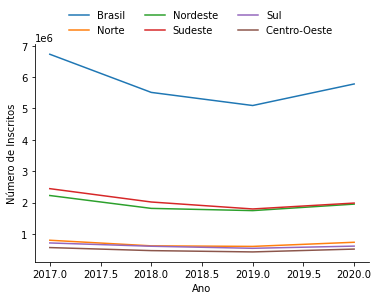

In [39]:
#fig, ax = plt.subplots(figsize=())
ax = sns.lineplot(data=inscritos, x='Ano', y='Número de Inscritos', hue='Região Geográfica')
sns.despine()
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

- Obeservando o gráfico acima, podemos perceber que o número de inscritos, desde 2017, sofre uma queda, até 2019, quando volta a subir, mas ainda sem recuperar o valor máximo do primeiro ano coletado.
- Sobre as regiões, o Sudeste possui mais inscritos, seguido pelo Nordeste, ambos com mais de 2 milhões. Seguindo o padrão dos dados do Brasil, também há uma queda até 2019, quando volta a crescer. Entretanto, a partir de 2019 a diferença entre o número de inscritos dessas duas regiões passa a ser menor.
- As outras três regiões (Norte, Sul e Centro-Oeste) possuem menos de um milhão de inscritos.

### 2. Médias das notas gerais
- Continuando nossa análise exploratória, vamos utilizar os dados das médias das notas totais do ENEM dos anos de 2020 a 2017, do Brasil e das regiões (questão 6, item f).

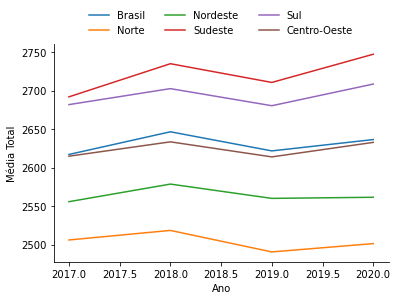

In [40]:
#fig, ax = plt.subplots(figsize=())
ax = sns.lineplot(data=nota_total_enem, x='Ano', y='Média Total', hue='Região Geográfica')
sns.despine()
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

In [41]:
nota_total_enem[(nota_total_enem['Média Total'] == nota_total_enem['Média Total'].max())]

,Região Geográfica,Ano,Média Total
3,Sudeste,2020,2747.09


In [42]:
nota_total_enem[(nota_total_enem['Média Total'] == nota_total_enem['Média Total'].min())]

,Região Geográfica,Ano,Média Total
7,Norte,2019,2490.49


- Sobre as notas gerais (soma das médias das cinco áreas de conhecimento), podemos destacar as notas do sudeste e do Sul, que são acima da média nacional. Em seguida, encontramos o Centro-Oeste bem próximo da média nacional, o Nordeste e o Norte.
- Em relação às edições do ENEM, os anos ímpares (2017 e 2019) tiveram os piores desempenhos, e os anos pares (2018 e 2020) tiveram melhores notas.
- A maior média total é do Sudeste em 2020 (2747.09) e a menor é do Norte em 2019 (2490.49)

### 3. Médias das notas por área de conhecimento
- A seguir, vamos utilizar os dados das médias das notas por área de conhecimento totais do ENEM dos anos de 2020 a 2017, do Brasil e das regiões (questão 6, itens a-e).

In [43]:
natureza = notas_area_enem[notas_area_enem['Área de conhecimento'] == 'CN']
humanas = notas_area_enem[notas_area_enem['Área de conhecimento'] == 'CH']
matematica = notas_area_enem[notas_area_enem['Área de conhecimento'] == 'MT']
linguagens = notas_area_enem[notas_area_enem['Área de conhecimento'] == 'LC']
redacao = notas_area_enem[notas_area_enem['Área de conhecimento'] == 'RD']

Text(0.5, 1.0, 'Total')

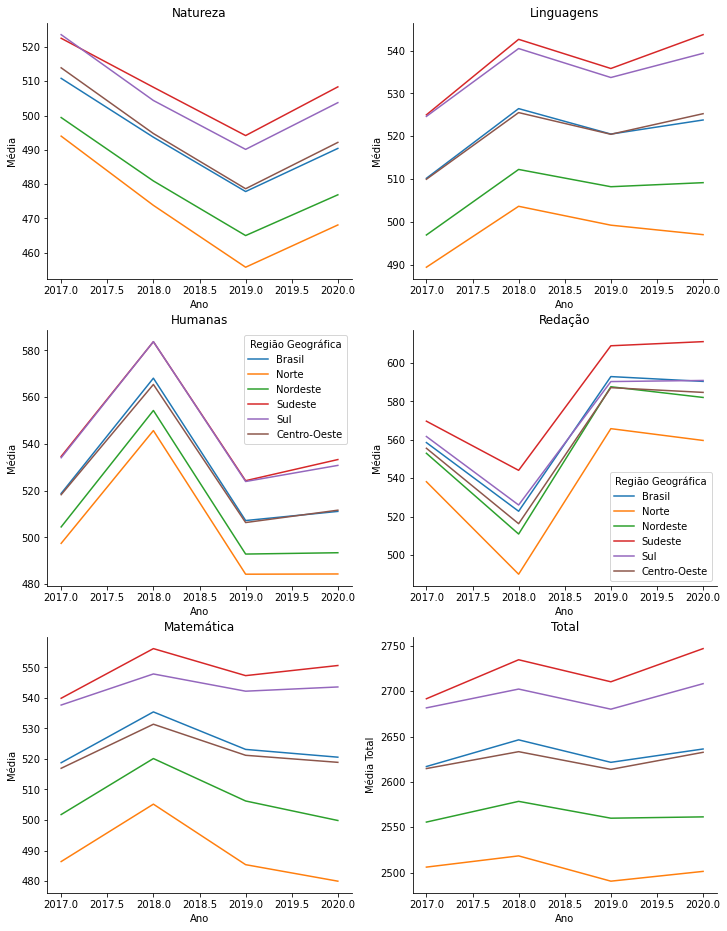

In [44]:
# Construindo os gráficos
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
# sns.move_legend(axes[0, 0], "lower center",
#     bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

sns.lineplot(ax=axes[0,0], data=natureza, x='Ano', y='Média', hue='Região Geográfica', legend=None)
sns.despine()
axes[0,0].set_title('Natureza')
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

sns.lineplot(ax=axes[1,0], data=humanas, x='Ano', y='Média', hue='Região Geográfica')
sns.despine()
axes[1,0].set_title('Humanas')

sns.lineplot(ax=axes[2,0], data=matematica, x='Ano', y='Média', hue='Região Geográfica', legend=None)
sns.despine()
axes[2,0].set_title('Matemática')

sns.lineplot(ax=axes[0, 1], data=linguagens, x='Ano', y='Média', hue='Região Geográfica', legend=None)
sns.despine()
axes[0,1].set_title('Linguagens')

sns.lineplot(ax=axes[1, 1], data=redacao, x='Ano', y='Média', hue='Região Geográfica')
sns.despine()
axes[1,1].set_title('Redação')

sns.lineplot(ax=axes[2, 1], data=nota_total_enem, x='Ano', y='Média Total', hue='Região Geográfica', 
             legend=None)
sns.despine()
axes[2,1].set_title('Total')

# # handles, labels = ax.get_legend_handles_labels()
# fig.legend(ax, loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, 
#            frameon=False)


In [45]:
print(natureza[(natureza['Média'] == natureza['Média'].max())], '\n',
      '\n', natureza[(natureza['Média'] == natureza['Média'].min())])

   Região Geográfica   Ano  Total de participantes       Média  Mediana  \
94               Sul  2017                  471640  523.609288    522.8   

     Moda  Mínimo  Máximo  Desvio Padrão Área de conhecimento  
94  538.7       0   853.0      71.679276                   CN   
 
    Região Geográfica   Ano  Total de participantes       Média  Mediana  \
31             Norte  2019                  423455  455.735664    446.2   

     Moda  Mínimo  Máximo  Desvio Padrão Área de conhecimento  
31  410.7       0   797.3      67.587595                   CN  


In [46]:
print(humanas[(humanas['Média'] == humanas['Média'].max())], '\n',
      '\n', humanas[(humanas['Média'] == humanas['Média'].min())])

   Região Geográfica   Ano  Total de participantes       Média  Mediana  Moda  \
70               Sul  2018                  450362  583.721612    599.7   0.0   

    Mínimo  Máximo  Desvio Padrão Área de conhecimento  
70       0   828.8      75.794189                   CH   
 
    Região Geográfica   Ano  Total de participantes       Média  Mediana  Moda  \
37             Norte  2019                  452261  484.309982    483.5   0.0   

    Mínimo  Máximo  Desvio Padrão Área de conhecimento  
37       0   786.7      77.312102                   CH  


In [47]:
print(linguagens[(linguagens['Média'] == linguagens['Média'].max())], '\n',
      '\n', linguagens[(linguagens['Média'] == linguagens['Média'].min())])

   Região Geográfica   Ano  Total de participantes       Média  Mediana  Moda  \
15           Sudeste  2020                  917487  543.694923    550.4   0.0   

    Mínimo  Máximo  Desvio Padrão Área de conhecimento  
15       0   801.1      69.992514                   LC   
 
     Região Geográfica   Ano  Total de participantes       Média  Mediana  \
103             Norte  2017                  542725  489.471459    493.1   

     Moda  Mínimo  Máximo  Desvio Padrão Área de conhecimento  
103   0.0       0   788.8      64.707365                   LC  


In [48]:
print(matematica[(matematica['Média'] == matematica['Média'].max())], '\n',
      '\n', matematica[(matematica['Média'] == matematica['Média'].min())])

   Região Geográfica   Ano  Total de participantes       Média  Mediana  \
81           Sudeste  2018                 1412525  556.136194    539.5   

     Moda  Mínimo  Máximo  Desvio Padrão Área de conhecimento  
81  470.4       0   996.1     108.184668                   MT   
 
    Região Geográfica   Ano  Total de participantes      Média  Mediana   Moda  \
19             Norte  2020                  297690  479.96596    460.3  415.9   

    Mínimo  Máximo  Desvio Padrão Área de conhecimento  
19       0   975.0      98.072272                   MT  


In [49]:
print(redacao[(redacao['Média'] == redacao['Média'].max())], '\n',
      '\n', redacao[(redacao['Média'] == redacao['Média'].min())])

   Região Geográfica   Ano  Total de participantes     Média  Mediana   Moda  \
27           Sudeste  2020                  897032  611.0951    600.0  560.0   

    Mínimo  Máximo  Desvio Padrão Área de conhecimento  
27      40  1000.0     177.695672                   RD   
 
    Região Geográfica   Ano  Total de participantes       Média  Mediana  \
85             Norte  2018                  445515  490.020987    480.0   

     Moda  Mínimo  Máximo  Desvio Padrão Área de conhecimento  
85  360.0      40  1000.0     159.357564                   RD  


- Analisando os dados e os gráficos acerca das notas médias por área de conhecimento, podemos destacar:
    - Em relação à tendência geral, as notas seguem a média total, na ordem: Sudeste, Sul, Brasil, Centro-Oeste, Nordeste e Norte. Apenas na área de Humanas, que as médias do Sudeste e do Sul são mais próximas;
    - Em relação aos anos, 2018 foi o ano com maiores médias para as áreas de Matemática, Humanas e Linguagens; 2019 para Redação e 2017 para Natureza;

### 4. Municípios e Escolas selecionados
- Na última seção de nossa análise exploratória, vamos utilizar a tabela que criamos com as escolas selecionadas para fazer um levantamento geral das cidades, notas do ENEM e alunos do ensino médio que vãi fazer parte do projeto.
- Primeiro, vamos contar as cidades por estados do Brasil.

In [50]:
escolas_final['Estado'].value_counts()

MA    21
PA    19
PI    19
AM    12
AL    10
BA     8
AC     3
PE     3
RR     2
PB     2
TO     1
Name: Estado, dtype: int64

- Temos 100 cidades divididas em 11 estados, todos eles das regiões Norte (5 estados e 37 municípios) e Nordeste (6 estados e 63 municípios). Lembrando da nossa análise das notas do ENEM, podemos perceber que realmente essas regiões são as que possuem os piores desempenhos. E que o projeto pode atuar nesse sentido de diminuir as disparidades regionais.
- Agora, vamos analisar os valores do IDHM 2010 e do IDHM Educação 2010, também a classificação das cidades das escolas selecionadas.

In [51]:
print(escolas_final[(escolas_final['IDHM 2010'] == escolas_final['IDHM 2010'].max())], '\n',
      '\n', escolas_final[(escolas_final['IDHM 2010'] == escolas_final['IDHM 2010'].min())], '\n',
     '\n', escolas_final['IDHM 2010'].mean())

               Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
97   Serrano do Maranhão     MA      0.519               0.433         Baixo   
100    Aroeiras do Itaim     PI      0.519               0.378         Baixo   
101    Santana do Mundaú     AL      0.519               0.362         Baixo   

     Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
97     426.05    400.71    427.76    404.29    388.00       409.36   
100    423.42    411.48    457.34    403.96    364.00       412.04   
101    461.78    457.27    495.39    494.41    550.24       491.82   

                                      Escola Escolhida  Alunos no EM  \
97                   JARDIM DE INFANCIA JOAO DE BARROS         280.0   
100                               UNID ESC SANTA MARIA          75.0   
101  ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL SAO VIC...         464.0   

     Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
97                             

In [52]:
escolas_final['Classificação'].value_counts()

Baixo          68
Muito Baixo    32
Name: Classificação, dtype: int64

In [53]:
print(escolas_final[(escolas_final['IDHM Educação 2010'] == escolas_final['IDHM Educação 2010'].max())], '\n',
      '\n', escolas_final[(escolas_final['IDHM Educação 2010'] == escolas_final['IDHM Educação 2010'].min())], '\n',
     '\n', escolas_final['IDHM Educação 2010'].mean())

   Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
66   Belágua     MA      0.512               0.455         Baixo     416.9   

    Média CH  Média LC  Média MT  Média RD  Média Total  \
66     391.9     439.3    389.12    266.67       380.78   

            Escola Escolhida  Alunos no EM  \
66  UI ROSALINA COSTA ARAUJO         309.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
66                              132.47                               180.0   
 
   Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
0   Melgaço     PA      0.418               0.207   Muito Baixo    435.15   

   Média CH  Média LC  Média MT  Média RD  Média Total  \
0     449.4    440.86    435.33    508.29       453.81   

           Escola Escolhida  Alunos no EM  Valor por aluno Jan-2019 (R$40932)  \
0  EMEIF O MUNDO DA CRIANCA         906.0                               45.18   

   Valor por aluno Dez-2020 (R$55620) 

- Os valores do IDHM 2010 dos 100 municípios escolhidos variam de 0.418 a 0.519, e a média é 0.5, limite entre as classificações "Muito Baixo" e "Baixo";
- 68% das cidades tem classificação como "Baixo" e 32% tem classificação como "Muito Baixo";
- Os valores do IDHM Educação 2010 dos 100 municípios escolhidos variam de 0.207 a 0.455, e a média é 0.348;
- Nosso próximo passo é analisar a quantidade de alunos matriculados no Ensino Médio nas escolas selecionadas.

In [54]:
print(escolas_final[(escolas_final['Alunos no EM'] == escolas_final['Alunos no EM'].max())], '\n',
      '\n', escolas_final[(escolas_final['Alunos no EM'] == escolas_final['Alunos no EM'].min())], '\n',
     '\n', escolas_final['Alunos no EM'].mean(), '\n',
     '\n', escolas_final['Alunos no EM'].sum())

   Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
53     Acará     PA      0.506               0.332         Baixo    437.55   

    Média CH  Média LC  Média MT  Média RD  Média Total  \
53    452.09    467.37    451.14    511.89       464.01   

               Escola Escolhida  Alunos no EM  \
53  EMEF SAO FRANCISCO DE ASSIS        1682.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
53                               24.34                               33.07   
 
              Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
100  Aroeiras do Itaim     PI      0.519               0.378         Baixo   

     Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
100    423.42    411.48    457.34    403.96     364.0       412.04   

         Escola Escolhida  Alunos no EM  Valor por aluno Jan-2019 (R$40932)  \
100  UNID ESC SANTA MARIA          75.0                              545.76   

     Valor

- De acordo com as escolas selecionadas, serão beneficiados 50242 alunos, distribuídos em escolas que possuem de 75 a 1682 estudantes matriculados no Ensino Médio.
- Agora, vamos analisar as notas médias do ENEM 2020 (geral e por área de conhecimento) das cidades selecionadas.

In [55]:
print(escolas_final[(escolas_final['Média Total'] == escolas_final['Média Total'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média Total'] == escolas_final['Média Total'].min())], '\n',
     '\n', escolas_final['Média Total'].mean())

          Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
29  Cocal dos Alves     PI      0.498               0.315   Muito Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
29    516.62    518.77    528.21    575.14    633.75        554.5   

                          Escola Escolhida  Alunos no EM  \
29  UNIDADE ESCOLAR SILVIA DE BRITO VIEIRA         205.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
29                              199.67                              271.32   
 
    Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
64  Ibiquera     BA      0.511               0.335         Baixo    403.77   

    Média CH  Média LC  Média MT  Média RD  Média Total  \
64    405.93    429.87    374.22     284.0       379.56   

                      Escola Escolhida  Alunos no EM  \
64  ESCOLA MUNICIPAL SENHOR DOS PASSOS         140.0   

    Valor por aluno Jan-2019 (R$40932)  Va

- Multiplicando os valores médios obtidos acima por 5, podemos comparar com os dados obtidos nas sinopses estatísticas do ENEM 2020:
    - Valor máximo: 2772,25;
    - Valor mínimo: 1897,8;
    - Valor médio: 2255,65;
- Comparando com a média geral do Brasil (2636), podemos perceber que o valor médio está bem abaixo, e o mínimo bem mais. Entretanto, o valor máximo está acima, demonstrando disparidades entre os municípios selecionados.

In [56]:
print(escolas_final[(escolas_final['Média CN'] == escolas_final['Média CN'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média CN'] == escolas_final['Média CN'].min())], '\n',
     '\n', escolas_final['Média CN'].mean())

         Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
1  Fernando Falcão     MA      0.443               0.286   Muito Baixo   

   Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
1     564.8     511.5     395.2     493.9     480.0       489.08   

                                    Escola Escolhida  Alunos no EM  \
1  UNIDADE INTEGRADA DE EDUCACAO ESCOLAR INDIGENA...         112.0   

   Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
1                              365.46                              496.61   
 
          Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
80  Brejo do Piauí     PI      0.515               0.354         Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
80    382.88    394.65    419.38    458.22     420.0       415.03   

                 Escola Escolhida  Alunos no EM  \
80  UNIDADE ESCOLAR SANTO ANTONIO         154.0   

    Valor por aluno Jan-20

In [57]:
print(escolas_final[(escolas_final['Média CH'] == escolas_final['Média CH'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média CH'] == escolas_final['Média CH'].min())], '\n',
     '\n', escolas_final['Média CH'].mean())

          Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
29  Cocal dos Alves     PI      0.498               0.315   Muito Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
29    516.62    518.77    528.21    575.14    633.75        554.5   

                          Escola Escolhida  Alunos no EM  \
29  UNIDADE ESCOLAR SILVIA DE BRITO VIEIRA         205.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
29                              199.67                              271.32   
 
                 Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
74  Senador José Porfírio     PA      0.514               0.338         Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
74    452.82    385.04    450.84    451.97    482.22       444.58   

               Escola Escolhida  Alunos no EM  \
74  EMEI SAO FRANCISCO DE ASSIS         483.0   

    Valor por aluno Jan-2019 (

In [58]:
print(escolas_final[(escolas_final['Média LC'] == escolas_final['Média LC'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média LC'] == escolas_final['Média LC'].min())], '\n',
     '\n', escolas_final['Média LC'].mean())

   Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
25  Olivença     AL      0.493               0.345   Muito Baixo    440.63   

    Média CH  Média LC  Média MT  Média RD  Média Total  \
25    495.51    535.51     479.2     720.0       534.17   

                            Escola Escolhida  Alunos no EM  \
25  ESCOLA MUNICIPAL SENADOR TEOTONIO VILELA         406.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
25                              100.82                               137.0   
 
        Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
45  Joca Marques     PI      0.504               0.353         Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
45     394.6     433.3     359.1    407.05     390.0       396.81   

                  Escola Escolhida  Alunos no EM  \
45  UNIDADE ESCOLAR TORQUATO FELIX         252.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por al

In [59]:
print(escolas_final[(escolas_final['Média MT'] == escolas_final['Média MT'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média MT'] == escolas_final['Média MT'].min())], '\n',
     '\n', escolas_final['Média MT'].mean())

          Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
29  Cocal dos Alves     PI      0.498               0.315   Muito Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
29    516.62    518.77    528.21    575.14    633.75        554.5   

                          Escola Escolhida  Alunos no EM  \
29  UNIDADE ESCOLAR SILVIA DE BRITO VIEIRA         205.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
29                              199.67                              271.32   
 
        Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  \
48  Jacareacanga     PA      0.505               0.279         Baixo   

    Média CN  Média CH  Média LC  Média MT  Média RD  Média Total  \
48     393.8    464.95    445.85    363.65     450.0       423.65   

                                    Escola Escolhida  Alunos no EM  \
48  ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL KARU ABOY        1048.0   

    Va

In [60]:
print(escolas_final[(escolas_final['Média RD'] == escolas_final['Média RD'].max())], '\n',
      '\n', escolas_final[(escolas_final['Média RD'] == escolas_final['Média RD'].min())], '\n',
     '\n', escolas_final['Média RD'].mean())

   Município Estado  IDHM 2010  IDHM Educação 2010 Classificação  Média CN  \
25  Olivença     AL      0.493               0.345   Muito Baixo    440.63   

    Média CH  Média LC  Média MT  Média RD  Média Total  \
25    495.51    535.51     479.2     720.0       534.17   

                            Escola Escolhida  Alunos no EM  \
25  ESCOLA MUNICIPAL SENADOR TEOTONIO VILELA         406.0   

    Valor por aluno Jan-2019 (R$40932)  Valor por aluno Dez-2020 (R$55620)  
25                              100.82                               137.0   
 
                           Município Estado  IDHM 2010  IDHM Educação 2010  \
16  São Francisco de Assis do Piauí     PI      0.485               0.336   

   Classificação  Média CN  Média CH  Média LC  Média MT  Média RD  \
16   Muito Baixo     454.1     470.6     511.9     425.8     240.0   

    Média Total        Escola Escolhida  Alunos no EM  \
16       420.48  UNID ESC TIA RICARDINA         151.0   

    Valor por aluno Jan-2019 (

- Observando os valores máximos, mínimos e as médias das notas do ENEM por área de conhecimento dos municípios selecionados, podemos destacar: 
    - Todas as áreas possuem o valor máximo acima da média nacional, mas o valor mínimo e médio das cidades abaixo do nacional;
    - Redação é a área com maior disparidade, 720 para máximo e 240 para mínimo, com 472 de média;
    - Destacamos a cidade de Cocal dos Alves (PI) que possui as melhores médias gerais (2772,5), de Matemática (575.14) e Ciências Humanas (518.77)

## Visualização dos Dados
### 1. Notas Gerais do ENEM
- Nesta seção, vamos organizar os principais pontos da análise exploratória em visualizações de gráficos. O primeiro terá a quantidade de inscritos em cada ano do ENEM entre 2017 e 2020. O segundo, uma comparação com as notas médias das áreas e a soma total das mesmas edições do exame analisadas. 

Text(0.05, -0.08, '©Ana Luiza Miranda                                                  Fonte: INEP')

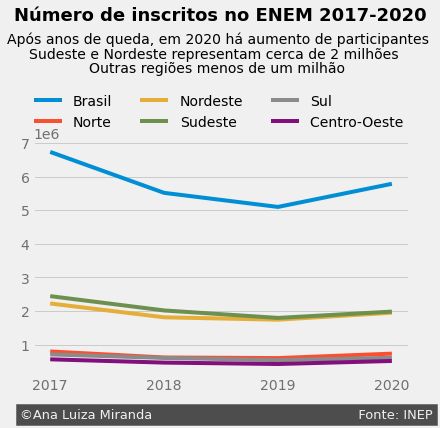

In [61]:
# Estabelecendo o estilo
style.use("fivethirtyeight")

# Criando a figura e o gráfico
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = sns.lineplot(data=inscritos, x='Ano', y='Número de Inscritos', hue='Região Geográfica')

sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
#ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.set_xticks([2017,2018,2019,2020])
ax.set_xticklabels([2017,2018,2019,2020])
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(axis='both', colors='#707070')

# Título e subtítulo
fig.text(x=0.035,y=1.3,s="Número de inscritos no ENEM 2017-2020",size=18, weight="bold")
fig.text(x=0.02,y=1.22,s="Após anos de queda, em 2020 há aumento de participantes",size=14)
fig.text(x=0.07,y=1.17,s="Sudeste e Nordeste representam cerca de 2 milhões",size=14)
fig.text(x=0.21,y=1.12, s="Outras regiões menos de um milhão",size=14)

#Rodapé:
fig.text(x=0.05, y=-0.08,s='©Ana Luiza Miranda' +' '*50 +"Fonte: INEP", backgroundcolor="#4d4d4d", size=13,color="#f0f0f0")

Text(0.05, 0.02, '©Ana Luiza Miranda                                                                              Fonte: INEP')

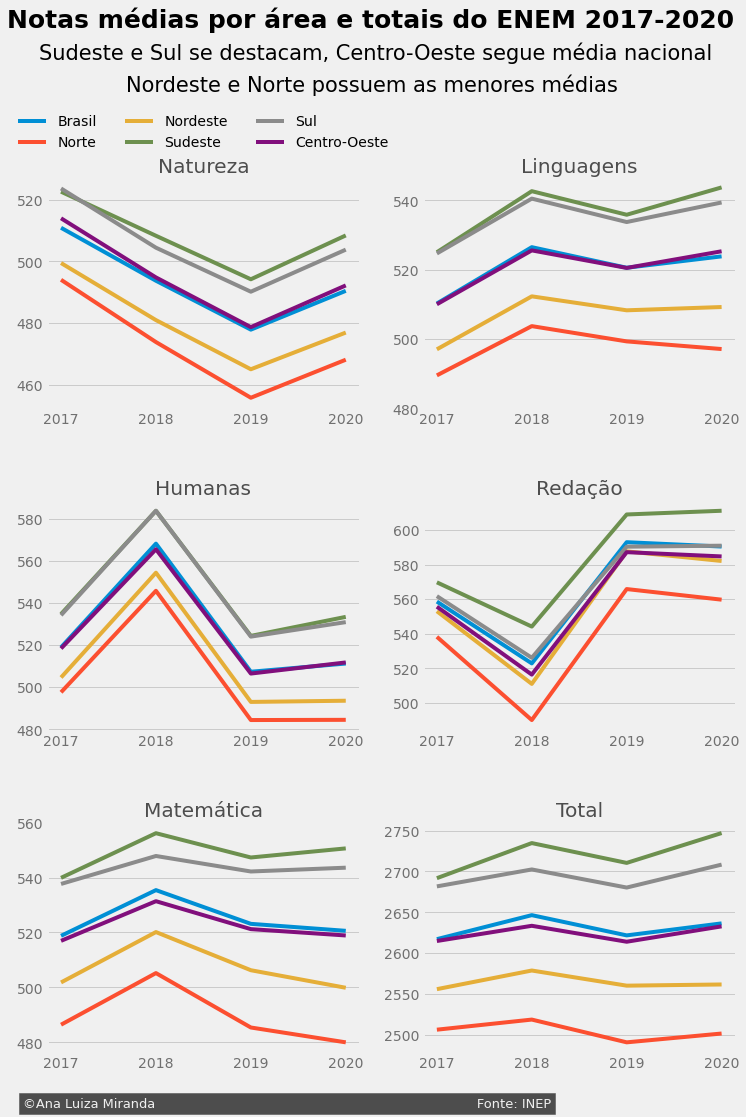

In [62]:
# Criando a figura e os gráficos
fig, axes = plt.subplots(3, 2, figsize=(11, 15))
fig.subplots_adjust(hspace=0.4)

sns.lineplot(ax=axes[0,0], data=natureza, x='Ano', y='Média', hue='Região Geográfica')
axes[0,0].set_title('Natureza', color="#4d4d4d")
sns.move_legend(axes[0,0], "center", bbox_to_anchor=(.5, 1.2), ncol=3, title=None, frameon=False)

axes[0,0].xaxis.grid(False)
axes[0,0].set_xticks([2017,2018,2019,2020])
axes[0,0].set_xticklabels([2017,2018,2019,2020])
axes[0,0].set_yticks([460,480,500,520])
axes[0,0].set_yticklabels([460,480,500,520])
axes[0,0].set_ylabel('')
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', colors='#707070')

sns.lineplot(ax=axes[1,0], data=humanas, x='Ano', y='Média', hue='Região Geográfica', legend=None)
axes[1,0].set_title('Humanas', color="#4d4d4d")
#axes[1,0].yaxis.grid(False)
axes[1,0].xaxis.grid(False)
axes[1,0].set_xticks([2017,2018,2019,2020])
axes[1,0].set_xticklabels([2017,2018,2019,2020])
axes[1,0].set_ylabel('')
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', colors='#707070')

sns.lineplot(ax=axes[2,0], data=matematica, x='Ano', y='Média', hue='Região Geográfica', legend=None)
axes[2,0].set_title('Matemática', color="#4d4d4d")
#axes[2,0].yaxis.grid(False)
axes[2,0].xaxis.grid(False)
axes[2,0].set_xticks([2017,2018,2019,2020])
axes[2,0].set_xticklabels([2017,2018,2019,2020])
axes[2,0].set_yticks([480,500,520,540,560])
axes[2,0].set_yticklabels([480,500,520,540,560])
axes[2,0].set_ylabel('')
axes[2,0].set_xlabel('')
axes[2,0].tick_params(axis='both', colors='#707070')

sns.lineplot(ax=axes[0, 1], data=linguagens, x='Ano', y='Média', hue='Região Geográfica', legend=None)
axes[0,1].set_title('Linguagens', color="#4d4d4d")
#axes[0,1].yaxis.grid(False)
axes[0,1].xaxis.grid(False)
axes[0,1].set_xticks([2017,2018,2019,2020])
axes[0,1].set_xticklabels([2017,2018,2019,2020])
axes[0,1].set_yticks([480,500,520,540])
axes[0,1].set_yticklabels([480,500,520,540])
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', colors='#707070')

sns.lineplot(ax=axes[1, 1], data=redacao, x='Ano', y='Média', hue='Região Geográfica', legend=None)
axes[1,1].set_title('Redação', color="#4d4d4d")
#axes[1,1].yaxis.grid(False)
axes[1,1].xaxis.grid(False)
axes[1,1].set_xticks([2017,2018,2019,2020])
axes[1,1].set_xticklabels([2017,2018,2019,2020])
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', colors='#707070')

sns.lineplot(ax=axes[2, 1], data=nota_total_enem, x='Ano', y='Média Total', hue='Região Geográfica',
             legend=None)
axes[2,1].set_title('Total', color="#4d4d4d")
#axes[2,1].yaxis.grid(False)
axes[2,1].xaxis.grid(False)
axes[2,1].set_xticks([2017,2018,2019,2020])
axes[2,1].set_xticklabels([2017,2018,2019,2020])
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].tick_params(axis='both', colors='#707070')

# Título e subtítulo
fig.text(x=0.03,y=1.02,s="Notas médias por área e totais do ENEM 2017-2020",size=25, weight="bold")
fig.text(x=0.07,y=0.99,s="Sudeste e Sul se destacam, Centro-Oeste segue média nacional",size=21)
fig.text(x=0.18,y=0.96, s="Nordeste e Norte possuem as menores médias",size=21)

#Rodapé:
fig.text(x=0.05, y=0.02,s='©Ana Luiza Miranda' +' '*78 +"Fonte: INEP", backgroundcolor="#4d4d4d", size=13,color="#f0f0f0")

### 2. Impacto do projeto
- Nesta seção, vamos visualizar os principais aspectos do projeto, a partir das escolas selecionadas, a localização dos municípios em que elas se encontra, o IDHM e a quantidade de alunos no Ensino Médio matriculado nessas escolas que cada estado possui.

In [63]:
# Abrindo o arquivo .shp para o mapa
bra_road = r'C:\Users\Suporte\desafio\BRA_adm2.shp'
geo_bra = gpd.read_file(bra_road)
geo_bra.head(2)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,33,BRA,Brazil,1,Acre,1,Acrelândia,Município,Municipality,None,None,"POLYGON ((-67.16084 -9.98260, -67.15184 -9.978..."
1,33,BRA,Brazil,1,Acre,2,Assis Brazil,Município,Municipality,None,None,"POLYGON ((-69.56518 -10.95550, -69.56603 -10.9..."


In [64]:
# Criando listas para filtrar os estados e municípios das escolas selecionadas
municipios = escolas_final['Município'].tolist()
estados = ['Acre', 'Alagoas', 'Amazonas', 'Bahia', 'Maranhão', 'Pará', 'Paraíba', 'Pernambuco', 'Piauí',
          'Roraima', 'Tocantins']

# Filtrando por estado
geo_bra['NAME_1'].astype(str)
geo_bra_estados = geo_bra[(geo_bra['NAME_1'].isin(estados))]

# Ajustes nas tabelas para criação da visualização
geo_bra['NAME_2'].astype(str)
escolas_final_estados = escolas_final.groupby('Estado', as_index=False).sum('Alunos no EM')

Text(0.05, 0.03, '©Ana Luiza Miranda                                                                              Fonte: INEP/Atlas Brasil')

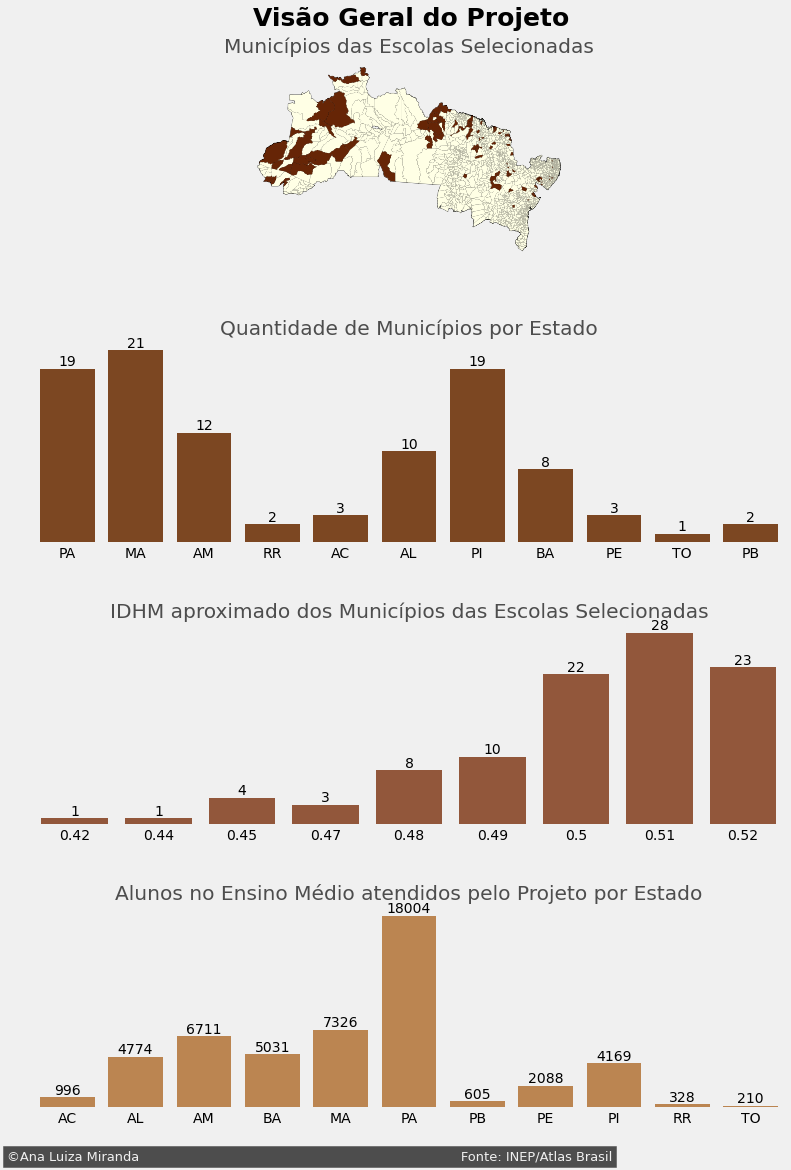

In [65]:
# Criação da figura e dos gráficos
fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(ncols=1, nrows=4, figsize=(12,18))
fig.subplots_adjust(hspace=0.4)

base = geo_bra_estados.plot(ax=ax1,facecolor="none", edgecolor="black")
ax1 = geo_bra_estados.plot(ax=base, column=geo_bra_estados['NAME_2'].isin(municipios), cmap='YlOrBr')
ax1.set_axis_off()
ax1.set_title('Municípios das Escolas Selecionadas', color="#4d4d4d")

ax2 = sns.countplot(ax=ax2, data=escolas_final, x='Estado', color='Saddlebrown')
ax2.bar_label(ax2.containers[0])
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.yaxis.grid(False)
ax2.xaxis.grid(False)
ax2.set_yticklabels([])
ax2.set_title('Quantidade de Municípios por Estado', color="#4d4d4d")

ax3 = sns.countplot(ax=ax3,data=escolas_final, x=escolas_final['IDHM 2010'].round(2), color='Sienna')
ax3.bar_label(ax3.containers[0])
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.yaxis.grid(False)
ax3.xaxis.grid(False)
ax3.set_yticklabels([])
ax3.set_title('IDHM aproximado dos Municípios das Escolas Selecionadas', color="#4d4d4d")

ax4 = sns.barplot(ax=ax4, data=escolas_final_estados, x='Estado', y='Alunos no EM', color='Peru')
ax4.bar_label(ax4.containers[0])
ax4.set_ylabel(None)
ax4.set_xlabel(None)
ax4.yaxis.grid(False)
ax4.xaxis.grid(False)
ax4.set_yticklabels([])
ax4.set_title('Alunos no Ensino Médio atendidos pelo Projeto por Estado', color="#4d4d4d")

#Título e subtítulo:
fig.text(x=0.335,y=0.905,s="Visão Geral do Projeto",size=25, weight="bold")

#Rodapé:
fig.text(x=0.05, y=0.03,s='©Ana Luiza Miranda' +' '*78 +"Fonte: INEP/Atlas Brasil", backgroundcolor="#4d4d4d", size=13,color="#f0f0f0")

## Conclusão
- Resumindo o projeto, na Introdução estabelecemos o objetivo de selecionar 100 escolas para receber 10 dólares por aluno/mês durante 12 meses, para turmas do ensino médio. Também o critério de escolher a partir dos menores valores de IDHM, mas cidades que possuíssem escolas de Ensino Médio com alunos que realizaram a prova do ENEM. Ademais, também respondemos algumas perguntas relacionadas ao tema, como notas médias do ENEM, número de inscritos e processo de tratamento de dados.
- Na Coleta de dados, apresentamos as cinco principais fontes de dados utilizadas (cotação do dólar para real, IDHM dos municípios do Brasil, microdados do ENEM 2020, microdados do Censo Escolar 2020 e Sinopses Estatísticas do ENEM 2017 a 2020).
- No Tratamento de dados, utilizamos vários métodos, como transformações de tipo, criação de filtros, classificação, separação por expressões regulares, agrupamento e mesclagem. Ao final, terminamos a seleção das 100 escolas que receberão o benefício e criamos uma tabela com elas e outras informações relevantes.
- Na Análise Exploratória, visualizamos e analisamos os dados das sinopses do ENEM 2017-2020, dos municípios e das escolas selecionadas.
- Na Visualização de dados, resumimos a análise em três figuras com os gráficos das notas (por área e geral) e inscritos do ENEM 2017-2020. Também destacamos as principais características das escolas e dos municípios selecionados a partir dos seus estados.
- Como conclusão, podemos destacar que as regiões que possuem menores notas médias no ENEM são Norte e Nordeste, também todas as cidades selecionadas com menores índices de IDHM são dessas regiões. O projeto dessa instituição é importante porque vai atuar nessas áreas mais necessitadas, ajudando a diminuir as disparidades regionais no Brasil.